In [27]:
import pandas as pd
import numpy as np
import collections

from datetime import datetime, timedelta 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from pycaret.regression import *
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
import xgboost

pd.set_option('display.max_columns', 50)

In [28]:
train = pd.read_csv('../input/train.csv')
train.head()

,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y
0,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,t,f,NaN,2016-07-13,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,138.0
1,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,This is a new listing for a lovely guest bedro...,2016-09-12,t,t,100%,2015-12-30,f,2017-03-31,38.934810,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,42.0
2,2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,We're looking forward to your stay at our apt....,2016-06-15,t,f,100%,2016-05-21,t,2017-08-13,40.695118,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,https://a0.muscache.com/im/pictures/5ffecc9b-d...,NaN,65.0
3,3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,2014-03-15,t,t,100%,2012-06-19,t,2017-09-03,37.796728,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,NaN,94133,166.0
4,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,Charming Apartment on the upper west side of M...,2015-08-05,t,t,100%,2015-03-25,f,2017-09-10,40.785050,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024,165.0


カテゴリデータを数値化しておく

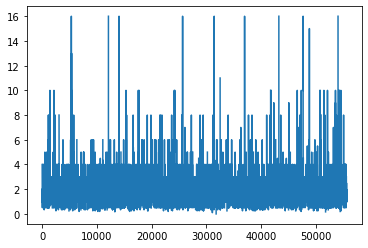

In [29]:
plt.plot(train['beds'] / train['bedrooms'])

In [30]:
# accommodates
train['accommodates'] = train['accommodates'].astype(float)

# bed par room
train['beds_per_room'] = train['beds'] * train['bedrooms']

# review date
train['first_review'] = train['first_review'].astype(str).apply(lambda x:x.replace('nan', '1999-01-01')).apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
train['host_since'] = train['host_since'].astype(str).apply(lambda x:x.replace('nan', '1999-01-01')).apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
train['review_date'] = (train['first_review'] - train['host_since']).apply(lambda x:x.total_seconds())

# last review date
train['last_review'] = train['last_review'].astype(str).apply(lambda x:x.replace('nan', '1999-01-01')).apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
train['last_review_date'] = (train['last_review'] - train['host_since']).apply(lambda x:x.total_seconds())

# keep date
train['keep_date'] = (train['last_review'] - train['first_review']).apply(lambda x:x.total_seconds())


# cancellation_policy
le = LabelEncoder()
le = le.fit(train['cancellation_policy'].astype(str))
train['cancellation_policy'] = le.transform(train['cancellation_policy'].astype(str))
train['cancellation_policy'] = train['cancellation_policy'].astype(float)

# host_response_rate
train['host_response_rate'] = train['host_response_rate'].astype(str).apply(lambda x: x.replace('%', '')).astype(float)

# neighbourhood
le = LabelEncoder()
#ラベルを覚えさせる
le = le.fit(train['neighbourhood'].astype(str))
#ラベルを整数に変換
train['neighbourhood'] = le.transform(train['neighbourhood'].astype(str))

# property_type
le = LabelEncoder()
le = le.fit(train['property_type'].astype(str))
train['property_type'] = le.transform(train['property_type'].astype(str))

# zipcode
#train['zipcode'] = train['zipcode'].astype(str).apply(lambda x : x[0:5].replace(' ', '0').replace('1m', '0').replace('Near', '0').replace('nan', '0') ).astype(int)
train['zipcode'] = train['zipcode'].astype(str).apply(lambda x : x[0:2].replace(' ', '0').replace('1m', '0').replace('Ne', '0').replace('na', '0') ).astype(float)

# rating
train['rating'] = (train['number_of_reviews'] * train['review_scores_rating'])

In [31]:
train = train[[#'id', 
               'accommodates',
               #'amenities', 
               'bathrooms', 
               'bed_type',
               'bedrooms',
               'beds', 
               'cancellation_policy', 
               'city',
               'cleaning_fee', 
               #'description',
               'first_review', 
               'host_has_profile_pic', 
               'host_identity_verified',
               'host_response_rate',
               'host_since', 
               'instant_bookable', 
               'last_review',
               'latitude', 
               'longitude', 
               #'name', 
               'neighbourhood',
               'number_of_reviews',
               'property_type', 
               'review_scores_rating', 
               'room_type', 
               #'thumbnail_url',
               'zipcode',
               'rating',
               'review_date',
               'last_review_date',
               'keep_date',
               'beds_per_room',
               'y']]

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55583 entries, 0 to 55582
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   accommodates            55583 non-null  float64       
 1   bathrooms               55436 non-null  float64       
 2   bed_type                55583 non-null  object        
 3   bedrooms                55512 non-null  float64       
 4   beds                    55487 non-null  float64       
 5   cancellation_policy     55583 non-null  float64       
 6   city                    55583 non-null  object        
 7   cleaning_fee            55583 non-null  object        
 8   first_review            55583 non-null  datetime64[ns]
 9   host_has_profile_pic    55435 non-null  object        
 10  host_identity_verified  55435 non-null  object        
 11  host_response_rate      41879 non-null  float64       
 12  host_since              55583 non-null  dateti

In [33]:
# train[['cancellation_policy', 'city', 'bed_type', 'cleaning_fee', 'host_has_profile_pic',
#       'host_identity_verified', 'instant_bookable', 'zipcode']].apply(lambda x: x.value_counts())

In [34]:
train_train = train.iloc[:50000,:]
train_test = train.iloc[50000:,:]

In [35]:
test =  pd.read_csv('../input/test.csv')
test.head()

,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode
0,0,6,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",2.0,Real Bed,2.0,2.0,strict,Boston,t,Feel free to book INSTANTLY. You can check-in ...,2017-01-09,t,f,100%,2016-08-23,t,2017-09-25,42.359278,-71.069962,Gorgeous 2BR/2BA Duplex in Beacon Hill,Beacon Hill,58,House,90.0,Entire home/apt,https://a0.muscache.com/im/pictures/7e4808b4-5...,02114
1,1,3,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,moderate,LA,t,The guest house is close to: Equinox West Holl...,2016-08-17,t,t,100%,2014-09-03,f,2017-05-02,34.084747,-118.367355,Luxury 1 Bedroom West Hollywood City Center,West Hollywood,4,Guesthouse,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/5392fbd6-6...,90046
2,2,2,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.0,Real Bed,0.0,1.0,flexible,NYC,f,Private room in a three bedroom apartment in N...,NaN,t,t,100%,2012-10-17,f,NaN,40.720541,-73.959192,Bedroom with Patio in Prime Williamsburg Locat...,Williamsburg,0,Apartment,NaN,Private room,https://a0.muscache.com/im/pictures/544d3b89-d...,11249.0
3,3,4,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,2.0,strict,NYC,f,The apartment is located in historic Bed Stuy ...,NaN,t,t,NaN,2013-01-23,f,NaN,40.681117,-73.944091,Cozy apartment in Brooklyn,Bedford-Stuyvesant,0,Apartment,NaN,Entire home/apt,https://a0.muscache.com/im/pictures/26baf7ba-0...,11216
4,4,3,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.5,Real Bed,1.0,2.0,strict,LA,t,"Our cozy, pet friendly one bedroom apartment/l...",2015-08-01,t,t,100%,2014-12-28,f,2016-09-11,34.150995,-118.409359,"Cozy, sunny, pet friendly loft/apt",NaN,6,Loft,92.0,Entire home/apt,https://a0.muscache.com/im/pictures/86107545/9...,91604


In [36]:
# accommodates
test['accommodates'] = test['accommodates'].astype(float)


# bed par room
test['beds_per_room'] = test['beds'] * test['bedrooms']

# review date
test['first_review'] = test['first_review'].astype(str).apply(lambda x:x.replace('nan', '1999-01-01')).apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
test['host_since'] = test['host_since'].astype(str).apply(lambda x:x.replace('nan', '1999-01-01')).apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
test['review_date'] = (test['first_review'] - test['host_since']).apply(lambda x:x.total_seconds())

# last review date
test['last_review'] = test['last_review'].astype(str).apply(lambda x:x.replace('nan', '1999-01-01')).apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
test['last_review_date'] = (test['last_review'] - test['host_since']).apply(lambda x:x.total_seconds())

# keep date
test['keep_date'] = (test['last_review'] - test['first_review']).apply(lambda x:x.total_seconds())


# cancellation_policy
le = LabelEncoder()
le = le.fit(test['cancellation_policy'].astype(str))
test['cancellation_policy'] = le.transform(test['cancellation_policy'].astype(str))
test['cancellation_policy'] = test['cancellation_policy'].astype(float)



# host_response_rate
test['host_response_rate'] = test['host_response_rate'].astype(str).apply(lambda x: x.replace('%', '')).astype(float)

# neighbourhood
le = LabelEncoder()
#ラベルを覚えさせる
le = le.fit(test['neighbourhood'].astype(str))
#ラベルを整数に変換
test['neighbourhood'] = le.transform(test['neighbourhood'].astype(str))

# property_type
le = LabelEncoder()
le = le.fit(test['property_type'].astype(str))
test['property_type'] = le.transform(test['property_type'].astype(str))

# zipcode
#test['zipcode'] = test['zipcode'].astype(str).apply(lambda x : x[0:5].replace('nan', '0').replace('.', '0')).astype(int)
test['zipcode'] = test['zipcode'].astype(str).apply(lambda x : x[0:2].replace('na', '0').replace('.', '0')).astype(float)


# rating
test['rating'] = test['number_of_reviews'] * test['review_scores_rating']

In [37]:
test =   test[[#'id', 
               'accommodates',
               #'amenities', 
               'bathrooms', 
               'bed_type',
               'bedrooms',
               'beds', 
               'cancellation_policy', 
               'city',
               'cleaning_fee', 
               #'description',
               'first_review', 
               'host_has_profile_pic', 
               'host_identity_verified',
               'host_response_rate',
               'host_since', 
               'instant_bookable', 
               'last_review',
               'latitude', 
               'longitude', 
               #'name', 
               'neighbourhood',
               'number_of_reviews',
               'property_type', 
               'review_scores_rating', 
               'room_type',
               #'thumbnail_url',
               'zipcode',
               'review_date',
               'last_review_date',
               'keep_date',  
               'rating',
               'beds_per_room',
]]

In [38]:
test['zipcode'].unique()

array([ 2., 90., 11., 91., 20., 94., 10., 60.,  0., 92., 93., 73., 21.,
       95.,  7.])

In [39]:
exp1 = setup(data = train_train, 
             test_data = train_test,
             target = 'y', 
             # ignore_features = None, 
             fold_shuffle= True, 
             #fold_strategy = tscv ,#'timeseries',
             data_split_shuffle = True)     

,Description,Value
0,session_id,7249
1,Target,y
2,Original Data,"(50000, 29)"
3,Missing Values,True
4,Numeric Features,16
5,Categorical Features,9
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(50000, 130)"


In [ ]:
#best = compare_models(['lightgbm', 'rf'])

IntProgress(value=0, description='Processing: ', max=14)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:12:18
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,52.6910,11470.7209,107.0427,0.5921,0.4175,0.3717,0.4630


In [40]:
best = create_model("lightgbm")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,52.5199,10928.6291,104.5401,0.6062,0.4150,0.3701
1,53.4004,12625.3327,112.3625,0.5718,0.4243,0.3805
2,52.0931,11420.7533,106.8679,0.5923,0.4189,0.3632
3,53.1557,12057.4760,109.8065,0.5930,0.4175,0.3661
4,54.0052,12404.2298,111.3743,0.5724,0.4217,0.3826
5,51.9021,10507.6313,102.5067,0.6012,0.4118,0.3670
6,49.9730,9852.4809,99.2597,0.5878,0.4067,0.3680
7,52.9852,11099.1918,105.3527,0.6212,0.4127,0.3676
8,51.7374,10883.6420,104.3247,0.6156,0.4196,0.3780
9,54.7198,12678.9028,112.6006,0.5732,0.4220,0.3660


In [41]:
final_best = finalize_model(best)

In [42]:
prediction = predict_model(best, data=test)


In [43]:
prediction = prediction.loc[:,['Label']]

In [44]:
prediction.to_csv("../output/prediction_add_categories_add_rating_diff_date_beds.csv", header=False)